### **Data Preparation**

**Import library**

In [ ]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from google.colab import drive

**Inisialisasi seed**

In [ ]:
# setting seed agar mendapat hasil akurasi yang lebih konsisten
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

**Menghubungkan Google Colab dengan Dataset di Goole Drive**

In [ ]:
drive.mount("/content/drive")
data_dir = "/content/drive/MyDrive/DeepL/Dataset"

Mounted at /content/drive


**Menghubungkan filepath untuk menyimpan model**

In [ ]:
# Definisikan path untuk menyimpan model CNN
checkpoint_dir = '/content/drive/MyDrive/deepl/Hasil'

# Fungsi untuk menyimpan model CNN
def save_keras_model(model, model_name, test_accuracy):
    timestamp = datetime.now().strftime("%Y%m%d")
    checkpoint_name = f"{model_name}_acc_{test_accuracy:.2f}_{timestamp}.h5"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model.save(checkpoint_path)
    print(f"Model disimpan di {checkpoint_path}")

In [ ]:
# Definisikan path untuk menyimpan model SVM
checkpoint_dir = '/content/drive/MyDrive/deepl/Hasil'

# Fungsi untuk menyimpan model SVM
def save_model_checkpoint(svm_model, model_name, test_accuracy):
    timestamp = datetime.now().strftime("%Y%m%d")
    checkpoint_name = f"{model_name}_acc_{test_accuracy:.2f}_{timestamp}.joblib"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    joblib.dump(svm_model, checkpoint_path)
    print(f"Model disimpan di {checkpoint_path}")

**Inisialisasi parameter default**

In [ ]:
# inisialisasi batch size dan image size (height & weight)
batch_size = 32
img_height = 224
img_width = 224

**Data preparation**

In [ ]:
# Muat dataset dari directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Tampilkan semua kelas dari dataset
class_names = dataset.class_names
print("Nama Kelas pada Dataset: ", class_names)

Found 710 files belonging to 9 classes.
Nama Kelas pada Dataset:  ['kupu_batik_cap', 'kupu_harimau_kuning', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']


**Visualisasi jumlah data di tiap kelas**


Jumlah data tiap kelas:
kupu_batik_cap: 100 gambar
kupu_harimau_kuning: 100 gambar
kupu_harimau_kuning_hijau: 100 gambar
kupu_hijau_biru: 100 gambar
kupu_jarak: 7 gambar
kupu_jojo: 100 gambar
kupu_pantat_merah: 95 gambar
kupu_raja_helena: 8 gambar
kupu_raja_limau: 100 gambar


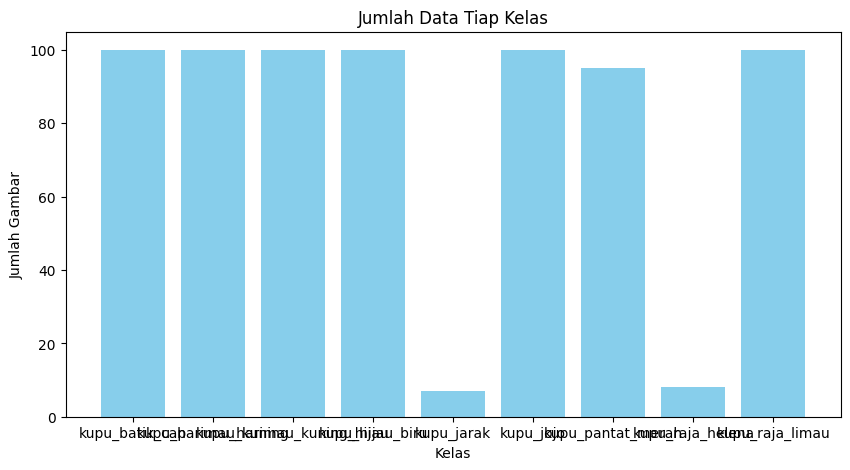

In [ ]:
# Inisialisasi variabel class_counts untuk menyimpan jumlah data tiap kelas
class_counts = {class_name: 0 for class_name in class_names}

# Hitung jumlah data tiap kelas
for images, labels in dataset:
    for label in labels:
        class_counts[class_names[label]] += 1

# Tampilkan jumlah data tiap kelas
print("\nJumlah data tiap kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} gambar")

# Visualisasi jumlah data tiap kelas menggunakan chart bar
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Jumlah Data Tiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

**Tampilkan gambar di tiap kelas**

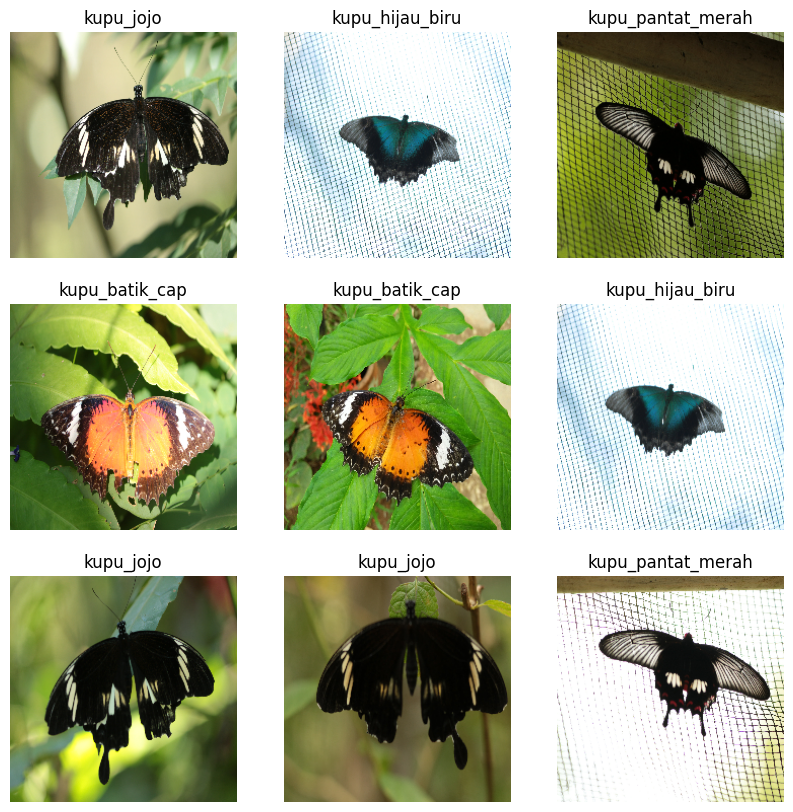

In [ ]:
# visualisasi data tiap kelas dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### **Preprocessing**

**Split data menjadi 3 pembagian**

In [ ]:
# Pembagian data training -> 70%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 70% untuk training
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi dan testing -> 30%
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Pembagian data validasi  -> 15%
val_ds = val_test_ds.take(len(val_test_ds) // 2)

# Pembagian data testing -> 15%
test_ds = val_test_ds.skip(len(val_test_ds) // 2)

Found 710 files belonging to 9 classes.
Using 497 files for training.
Found 710 files belonging to 9 classes.
Using 213 files for validation.


**Hitung jumlah gambar di masing-masing proporsi data**

In [ ]:
num_train_files = sum([len(labels) for images, labels in train_ds])
num_val_files = sum([len(labels) for images, labels in val_ds])
num_test_files = sum([len(labels) for images, labels in test_ds])

print(f"Jumlah Data di Dataset Training: {num_train_files}")
print(f"Jumlah Data di Dataset Validasi: {num_val_files}")
print(f"Jumlah Data di Dataset Testing: {num_test_files}")

Jumlah Data di Dataset Training: 497
Jumlah Data di Dataset Validasi: 96
Jumlah Data di Dataset Testing: 117


**Augmentasi dan normalisasi data menggunakan ImageDataGenerator**

In [ ]:
# Augmentasi dan Normalisasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalisasi data validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

### **Pembuatan Model**

Shuffle Net